# example: Keras 1D convolutional neural network on SUSY data

# SUSY Data Set

- <https://archive.ics.uci.edu/ml/datasets/SUSY>
- <http://arxiv.org/abs/1402.4735>

The SUSY Data Set is a classification problem to distinguish between a signal process which produces supersymmetric particles and a background process which does not. In the data, the first column is the class label (1 for signal, 0 for background), followed by 18 features (8 low-level features and 10 high-level features):

- lepton 1 pT
- lepton 1 eta
- lepton 1 phi
- lepton 2 pT
- lepton 2 eta
- lepton 2 phi
- missing energy magnitude
- missing energy phi
- MET_rel
- axial MET
- M_R
- M_TR_2
- R
- MT2
- S_R
- M_Delta_R
- dPhi_r_b
- cos(theta_r1)

This data has been produced by MadGraph5 Monte Carlo simulations of 8 TeV proton collisions, with showering and hadronisation performed by Pythia 6 and detector response simulated by Delphes. The first 8 features are kinematic properties measured by simulated particle detectors. The next 10 features are functions of the first 8 features; they are high-level features derived by physicists to help discriminate between the two classes. There are 46% positive examples in the SUSY data set. The features were standardised over the entire training/testing sets with mean zero and standard deviation one, except for those features with values strictly greater than zero; these were scaled such that the mean value was one.

In [1]:
import datetime
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.utils import plot_model
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style = 'ticks')
sns.set_palette('husl')
import talos as ta

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [17, 10]

In [3]:
df = pd.read_csv(
    "SUSY_100k.csv",
    names = [
        "classification",
        "lepton_1_pT",
        "lepton_1_eta",
        "lepton_1_phi",
        "lepton_2_pT",
        "lepton_2_eta",
        "lepton_2_phi",
        "missing_energy_magnitude",
        "missing_energy_phi",
        "MET_rel",
        "axial_MET",
        "M_R",
        "M_TR_2",
        "R",
        "MT2",
        "S_R",
        "M_Delta_R",
        "dPhi_r_b",
        "cos_theta_r1"
    ]
)
df.head()

,classification,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


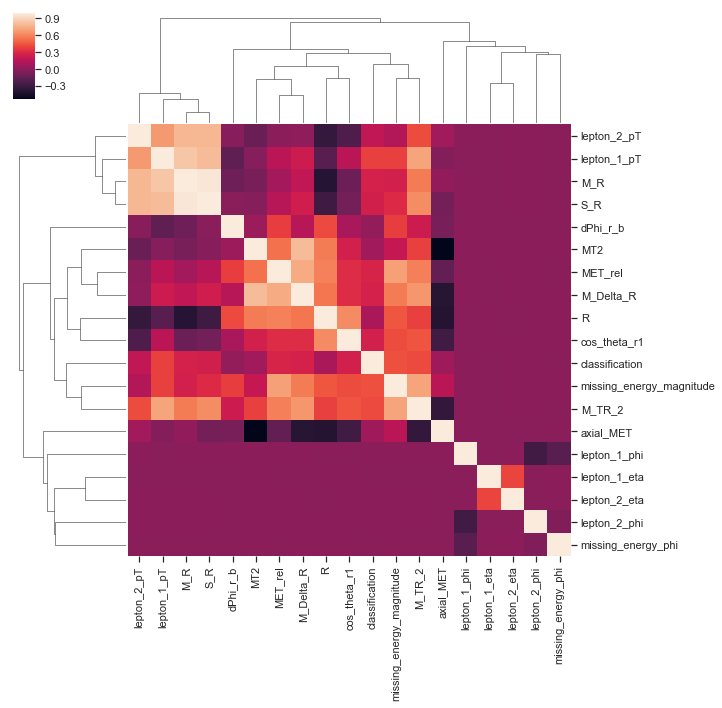

In [4]:
plot = sns.clustermap(df.corr())
_ = plt.setp(plot.ax_heatmap.get_yticklabels(), rotation = 0)

In [5]:
#sns.pairplot(df, hue = "classification");

In [6]:
df['labels'] = df['classification'].astype('category').cat.codes
x = df.drop(columns = ['classification', 'labels']).values.astype('float32')
y = df['classification']
# Convert class vectors to binary class matrices using 1 hot encoding.
# 0 ---> 1, 0, 0
# 1 ---> 0, 1, 0
# 2 ---> 0, 0, 1
num_classes = len(y.unique())
y_raw = y # non-categorical
y = keras.utils.to_categorical(y, len(y.unique()))

x = np.asarray(x)
y = np.asarray(y)

x = x.reshape(len(x), 18, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, shuffle = True)

In [7]:
# Define a callback class which is to be passed to the model fitting function
# as an element of a list of possible callbacks.
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs = {}):
        self.acc = []
    def on_epoch_end(self, batch, logs = {}):
        self.acc.append(logs.get('acc'))

class NBatchLogger(keras.callbacks.Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['steps'],
                                          metrics_log))
            self.metric_cache.clear()
        
history = AccuracyHistory()

In [8]:
model = Sequential()
model.add(Conv1D(32, (5), strides = (1), input_shape = (18, 1), activation = 'relu'))
model.add(MaxPooling1D(pool_size = (2), strides = (2)))
model.add(Conv1D(32, (3), strides = (1), input_shape = (18, 1), activation = 'relu'))
#model.add(Dropout(rate = 0.5))
model.add(Flatten())
model.add(Dense(300,                                            activation = 'relu'))
#model.add(Dropout(rate = 0.5))
model.add(Dense(300,                                            activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(num_classes,                                    activation = 'softmax'))
model.compile(loss = "categorical_crossentropy", optimizer = "nadam", metrics = ['accuracy'])
#plot_model(model, to_file = "model.png")
model.summary()

epochs     = 100
batch_size = 200

model.fit(
    x_train,
    y_train,
    batch_size      = batch_size,
    epochs          = epochs,
    verbose         = False,
    validation_data = (x_test, y_test),
    callbacks       = [history]
)

score = model.evaluate(x_test, y_test, verbose = False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14, 32)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 32)             3104      
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               48300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
__________

test loss: 0.5510452810764312
test accuracy: 0.7783


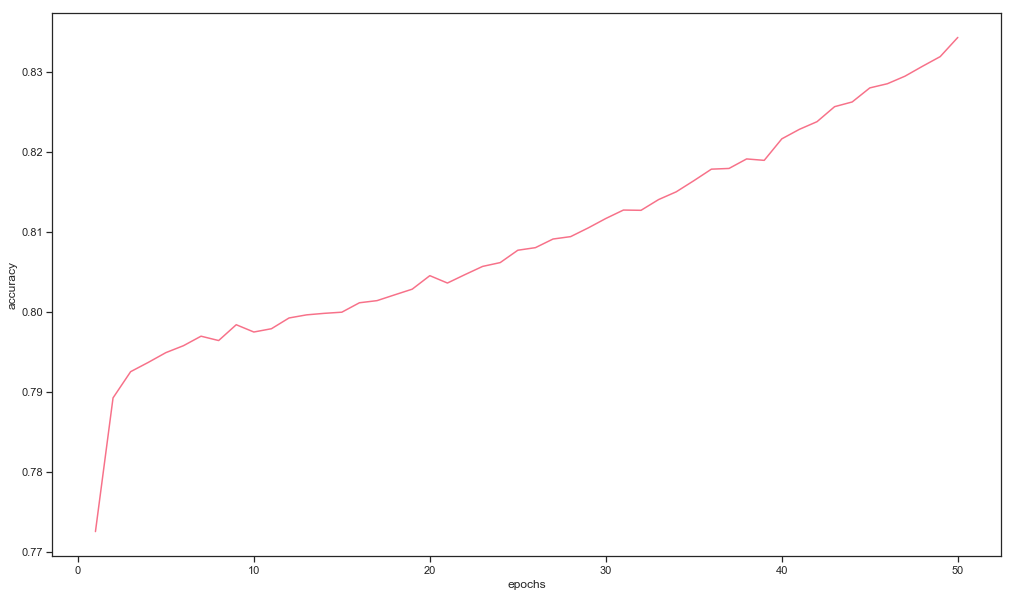

In [9]:
print('test loss:', score[0])
print('test accuracy:', score[1])
plt.plot(range(1, epochs + 1), history.acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [10]:
y_pred = model.predict(x_test)

y_test_non_categorical = np.argmax(y_test, axis=1)
y_pred_non_categorical = np.argmax(y_pred, axis=1)

fpr, tpr, thresholds = roc_curve(y_test_non_categorical, y_pred_non_categorical)
auc_data = auc(fpr, tpr)

##plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr, tpr, label = 'model (area = {:.3f})'.format(auc_data))
#plt.xlabel('false positive rate')
#plt.ylabel('true positive rate')
#plt.title('ROC curve')
##plt.legend(loc = 'best')
#plt.show()

In [11]:
df = pd.DataFrame(columns = ["y_test", "y_pred"])
df["y_test"] = y_test_non_categorical.tolist()
df["y_pred"] = y_pred_non_categorical.tolist()
df["equal"]  = df.apply(lambda row: "correct" if row["y_test"] == row["y_pred"] else "incorrect", axis = 1)
df["equal"].value_counts() / len(df)

correct      0.7783
incorrect    0.2217
Name: equal, dtype: float64

  0%|          | 0/4 [00:00<?, ?it/s]

{'batch_size': 128, 'epochs': 2000, 'dropout': 0.5, 'activation': 'tanh', 'dense_1': 100, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.46073253388404845
test accuracy: 0.787


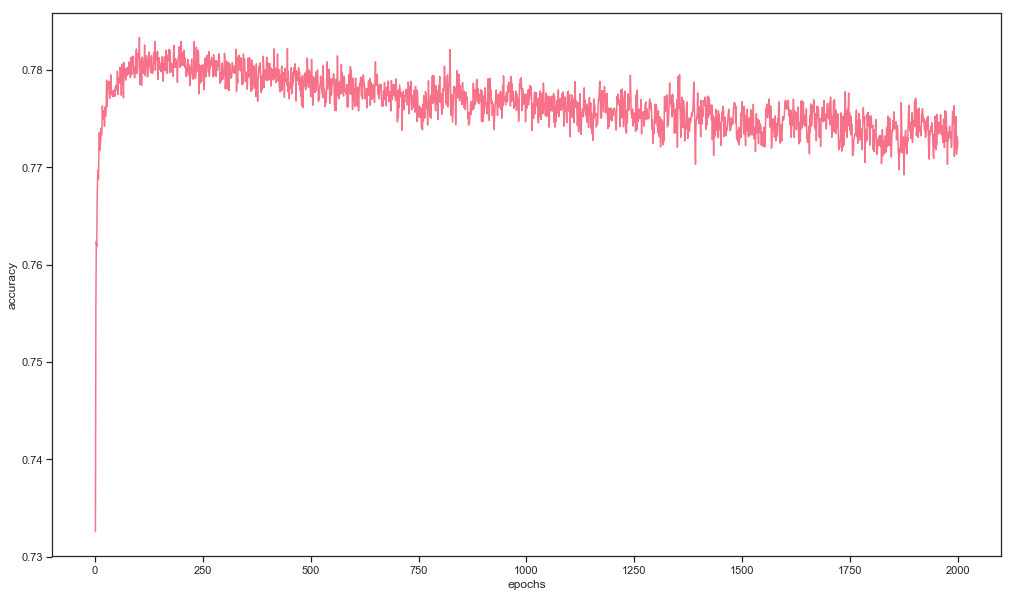

 25%|██▌       | 1/4 [1:08:44<3:26:13, 4124.64s/it]

{'batch_size': 128, 'epochs': 2000, 'dropout': 0.5, 'activation': 'tanh', 'dense_1': 50, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.4558246510187785
test accuracy: 0.7891666666666667


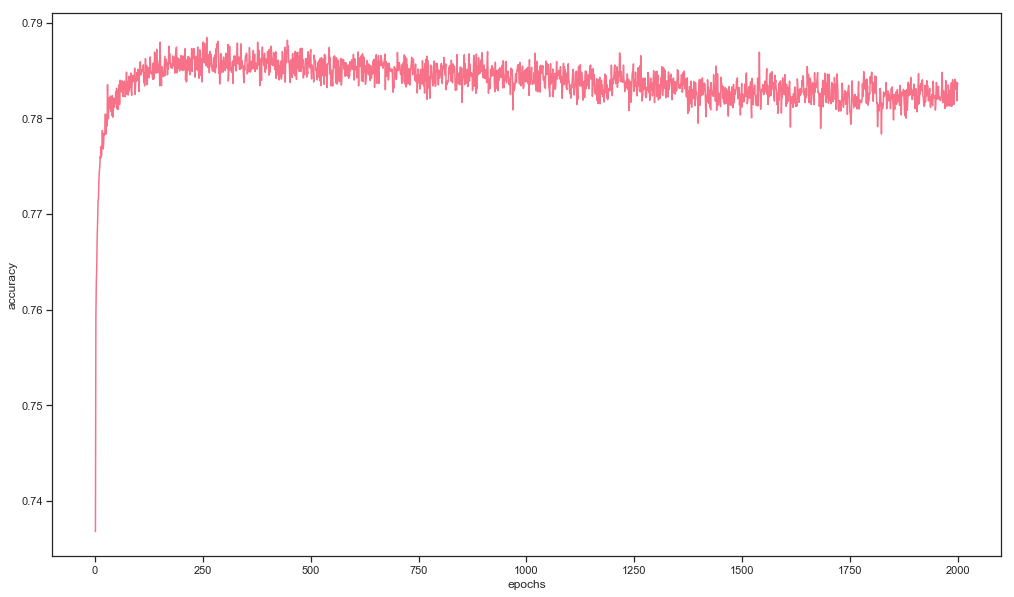

 50%|█████     | 2/4 [2:17:14<2:17:20, 4120.25s/it]

{'batch_size': 128, 'epochs': 2000, 'dropout': 0.5, 'activation': 'relu', 'dense_1': 100, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.492088872996966
test accuracy: 0.7783333333333333


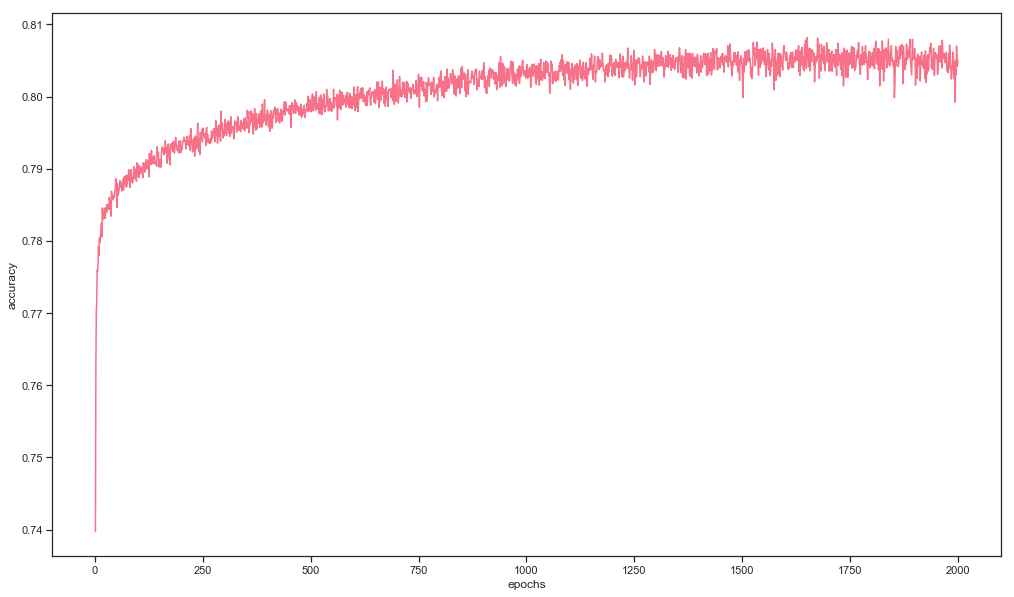

 75%|███████▌  | 3/4 [3:25:47<1:08:38, 4118.15s/it]

{'batch_size': 128, 'epochs': 2000, 'dropout': 0.5, 'activation': 'relu', 'dense_1': 50, 'optimizer': 'nadam', 'losses': 'categorical_crossentropy'}
test loss: 0.4866225830554962
test accuracy: 0.7830666666666667


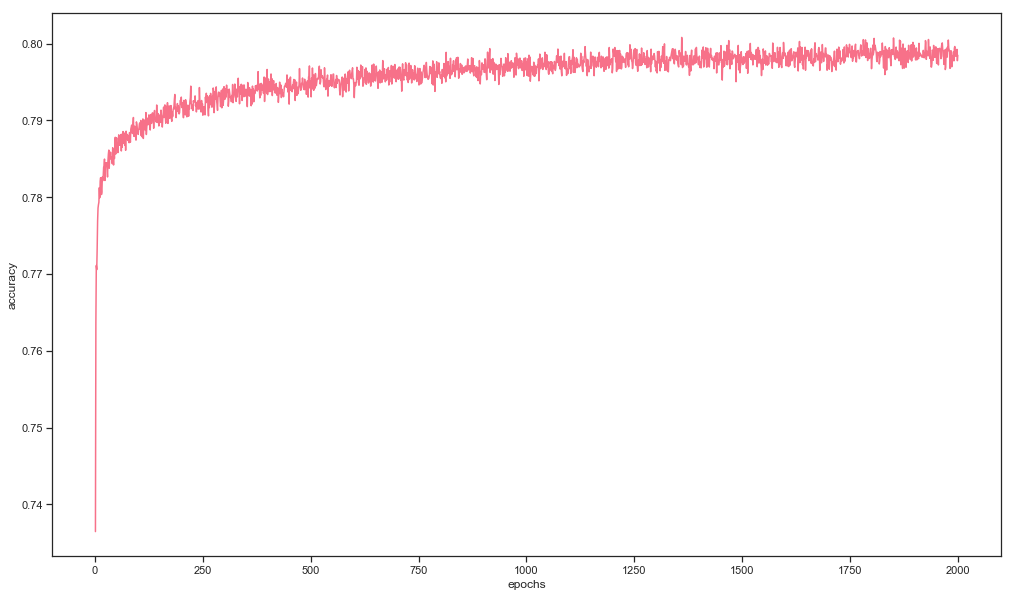

100%|██████████| 4/4 [4:34:25<00:00, 4117.97s/it]  


In [12]:
parameters = {
    'batch_size': [128],
    'epochs'    : [2000],
    'dropout'   : [0.5],
    'activation': ['tanh', 'relu'],
    'dense_1'   : [50, 100],
    'optimizer' : ['nadam'],
    'losses'    : ['categorical_crossentropy'],
}

def hmodel_convolutional(
    x_train,
    y_train,
    x_test,
    y_test,
    parameters = parameters
    ):
    model = Sequential()
    model.add(Conv1D(32, (5), strides = (1), input_shape = (18, 1), activation = parameters['activation']))
    model.add(Dropout(rate = parameters['dropout']))
    model.add(MaxPooling1D(pool_size = (2), strides = (2)))
    #model.add(Dropout(rate = parameters['dropout']))
    model.add(Conv1D(32, (3), strides = (1), input_shape = (18, 1), activation = parameters['activation']))
    model.add(Dense(parameters['dense_1'],                          activation = parameters['activation']))
    #model.add(Dropout(rate = parameters['dropout']))
    model.add(Flatten())
    model.add(Dense(parameters['dense_1'],                          activation = parameters['activation']))
    #model.add(Dropout(rate = parameters['dropout']))
    model.add(Dense(parameters['dense_1'],                          activation = parameters['activation']))
    model.add(Dropout(rate = parameters['dropout']))
    model.add(Dense(num_classes,                                    activation = 'softmax'))
    model.compile(
        loss      = parameters['losses'],
        optimizer = parameters['optimizer'],
        metrics   = ['accuracy']
    )
    #filepath = datetime.datetime.utcnow().strftime("%Y-%m-%dT%H%M%SZ") + ".png"
    #plot_model(model, to_file = filepath)
    #plot_model(model, to_file = "model.png")
    #print(model.summary())
    out = model.fit(
        x_train,
        y_train,
        batch_size      = parameters['batch_size'],
        epochs          = parameters['epochs'],
        verbose         = False,
        validation_data = [x_test, y_test],
        callbacks       = [history]
    )
    score = model.evaluate(x_test, y_test, verbose = False)
    print('test loss:', score[0])
    print('test accuracy:', score[1])
    plt.plot(range(1, parameters['epochs'] + 1), history.acc)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()
    return out, model

h = ta.Scan(
    x                = x,
    y                = y,
    params           = parameters,
    dataset_name     = 'SUSY',
    experiment_no    = '1',
    model            = hmodel_convolutional,
    grid_downsample  = 1,
    #reduction_method = None
    reduction_method = 'correlation',
    print_params     = True
)

In [13]:
r = ta.Reporting(h)
r.data.sort_values(by = ['acc'], ascending = False)

,round_epochs,val_loss,val_acc,loss,acc,batch_size,epochs,dropout,activation,dense_1,optimizer,losses
2,2000,0.441268,0.796767,0.418343,0.808186,128,2000,0.5,relu,100,nadam,categorical_crossentropy
3,2000,0.439660,0.797233,0.431946,0.800800,128,2000,0.5,relu,50,nadam,categorical_crossentropy
1,2000,0.446514,0.793700,0.458018,0.788443,128,2000,0.5,tanh,50,nadam,categorical_crossentropy
0,2000,0.447509,0.794700,0.466538,0.783314,128,2000,0.5,tanh,100,nadam,categorical_crossentropy


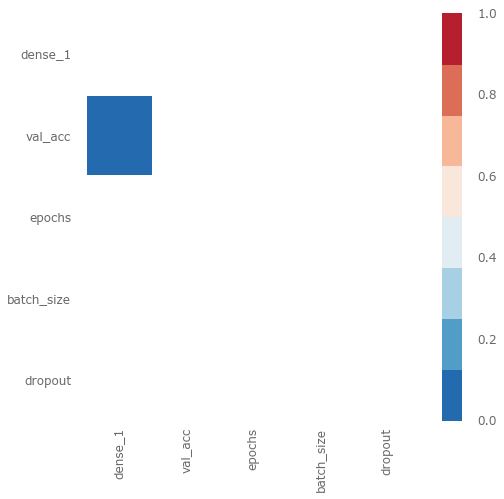

In [14]:
r.plot_corr()

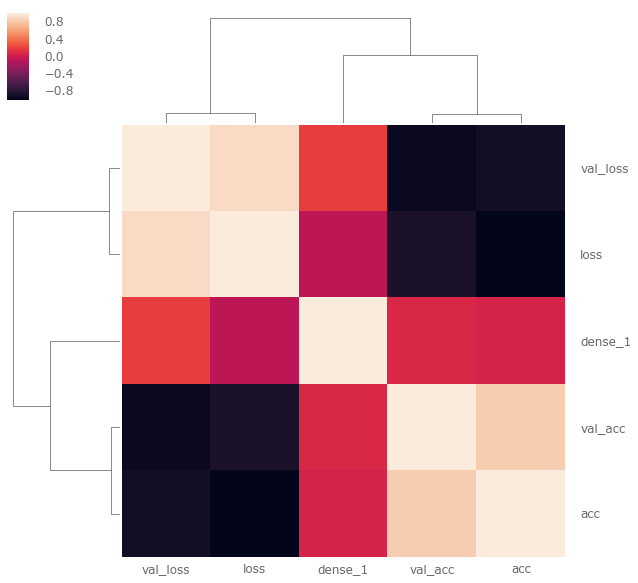

In [16]:
df = r.data[['val_loss', 'val_acc', 'loss', 'acc', 'dense_1']]
plot = sns.clustermap(df.corr())
_ = plt.setp(plot.ax_heatmap.get_yticklabels(), rotation = 0)